# TP5 : Project

This TP will help you to participate to the competition in [Codalab](https://competitions.codalab.org/competitions/22714?secret_key=82d6b877-808f-4716-a313-5dbdeafa22b5).  
*Reminder : The objectiv is to obtain the best-possible model to automatically classify the land cover of this kind of landscapes :*   
![mozaic](https://docs.google.com/uc?export=download&id=1HypyX6kYGjEdt8M7E_J2JDy29BppoGkr)  

# I - Download and process the data

In [0]:
#We shut down tf 2.0 deprecated warning
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

device = tf.test.gpu_device_name()

if device=='/device:GPU:0':
    print ("You're ready for the course !")
else :
    print("You are still running on CPU.")

You're ready for the course !


In [0]:
#Loading the dataset
!wget -nv https://cerfacs.fr/opendata/cours/data/TRAIN.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/TEST.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/y_train.npy

2020-03-27 13:31:34 URL:https://cerfacs.fr/opendata/cours/data/TRAIN.tar [44851200/44851200] -> "TRAIN.tar.7" [1]
2020-03-27 13:31:41 URL:https://cerfacs.fr/opendata/cours/data/TEST.tar [15687680/15687680] -> "TEST.tar.7" [1]
2020-03-27 13:31:44 URL:https://cerfacs.fr/opendata/cours/data/y_train.npy [1600128/1600128] -> "y_train.npy.7" [1]


In [0]:
#Using tarfile to create np arrays
import tarfile
import numpy as np
from PIL import Image

def extract_files(dataset):
  tar = tarfile.open(dataset+'.tar', 'r')
  names = tar.getmembers()[:]
  images = [tar.extractfile(name) for name in names]

  return (np.array([np.array(Image.open(image)) for image in images]))

X_train_all = extract_files('TRAIN')
X_test = extract_files('TEST')

y_train_all = np.load('y_train.npy')

In [0]:
#One Hot Encoding data
from sklearn.preprocessing import OneHotEncoder
y_train_all = np.load('y_train.npy').reshape(-1, 1)

print (f"Shape before OHE : {y_train_all.shape}\n")
encoder = OneHotEncoder()
y_train_all = encoder.fit_transform(y_train_all).toarray()
print (f"Shape after OHE : {y_train_all.shape}")
print (f"Example of label OHE : {y_train_all[0]}")

X_train, y_train = X_train_all[:19500], y_train_all[:19500]
X_valid, y_valid = X_train_all[19500:], y_train_all[19500:]

80:20

X_train, X_valid, X_test = X_train/255, X_valid/255, X_test/255

print(X_valid.shape)

Shape before OHE : (20000, 1)

Shape after OHE : (20000, 10)
Example of label OHE : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(500, 64, 64, 3)


# II - Simple model

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights=None, include_top=False, input_shape=(64, 64, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [0]:
#####Correction#######
import keras
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

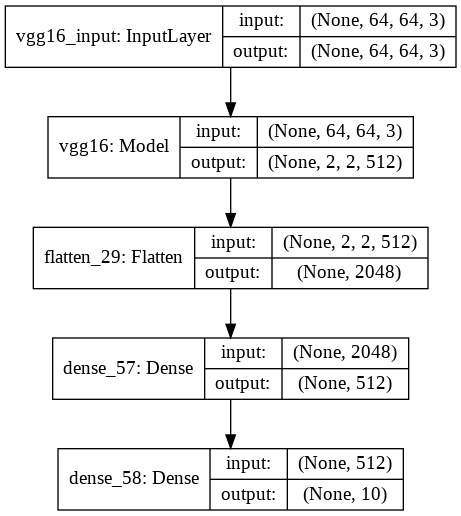

In [0]:
keras.utils.plot_model(model, show_shapes=True)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
    )

In [0]:
# for layer in conv_base.layers:
    # layer.trainable = False

for layer in conv_base.layers:
    layer.trainable = True

# for layer in conv_base.layers:
#   if layer.name[:6]=="block5":
#     layer.trainable = True

for layer in conv_base.layers:    
  print(layer.name, layer.trainable)

input_30 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [0]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

epochs = 100

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=3e-5),
              metrics=['accuracy'])              

callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, verbose=1),
           EarlyStopping(monitor='val_loss', patience=15, verbose=1),
           ModelCheckpoint('CNN.h5', monitor='val_loss', verbose=1, save_best_only=True)]

train_flow = train_datagen.flow(X_train, y_train, batch_size=32) 
history = model.fit_generator(train_flow, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
610/610 [==============================] - 31s 51ms/step - loss: 1.6490 - acc: 0.3579 - val_loss: 1.3064 - val_acc: 0.4680

Epoch 00001: val_loss improved from inf to 1.30637, saving model to CNN.h5
Epoch 2/100
610/610 [==============================] - 24s 39ms/step - loss: 1.2194 - acc: 0.5376 - val_loss: 1.3854 - val_acc: 0.5060

Epoch 00002: val_loss did not improve from 1.30637
Epoch 3/100
610/610 [==============================] - 24s 39ms/step - loss: 1.0780 - acc: 0.5959 - val_loss: 0.9753 - val_acc: 0.6320

Epoch 00003: val_loss improved from 1.30637 to 0.97533, saving model to CNN.h5
Epoch 4/100
610/610 [==============================] - 24s 39ms/step - loss: 0.9595 - acc: 0.6444 - val_loss: 0.8781 - val_acc: 0.6820

Epoch 00004: val_loss improved from 0.97533 to 0.87808, saving model to CNN.h5
Epoch 5/100
610/610 [==============================] - 25s 40ms/step - loss: 0.8708 - acc: 0.6753 - val_loss: 0.7532 - val_acc: 0.7260

Epoch 00005: val_loss improved from 

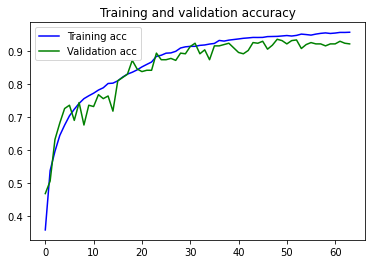

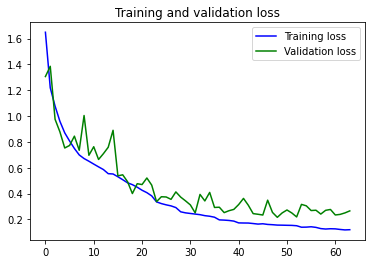

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

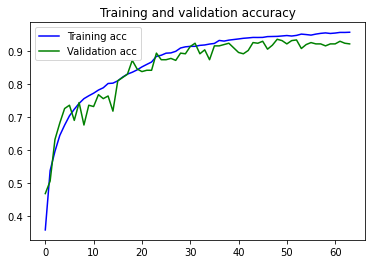

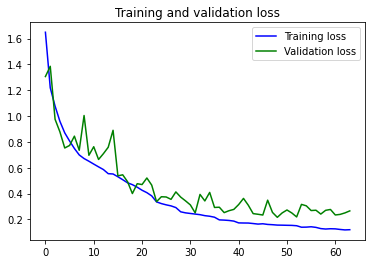

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# III - Help to create your submission

Once your model will be trained, you can try to submit your predictions on Codalab.  
However, the output of your model is most likely a binary vector of size 10 instead of the land cover label expected.  
We will have to do the reverse conversion operation that we did during the pre-processing step:  

In [0]:
predictions = model.predict(X_test)
print (f"Prediction before conversion : {predictions[0]}\n")
predictions = encoder.inverse_transform(predictions)
print (f"Prediction after conversion : {predictions[0]}")

Prediction before conversion : [3.0409623e-04 5.8180867e-03 2.2256123e-05 1.8523656e-06 1.8082650e-12
 9.9373794e-01 5.7871637e-07 4.1443624e-10 1.1359020e-04 1.5889593e-06]

Prediction after conversion : ['Pasture']


And that's it, we can now use this create_submission function to generate a submission.zip bundle (In the "Fichiers" tab on the left) that can be submitted into Codalab [here](https://competitions.codalab.org/competitions/22178?secret_key=5c393ddf-f713-4562-bc9d-72188be56146).

In [0]:
def create_submission(predictions):
  import os
  assert predictions.shape==(7000, 1), f"Wrong shape for your prediction file : "\
                                      f"{predictions.shape} instead of (17544, 1)" 
  if os.path.exists("submission.zip"):
    !rm submission.zip
  np.save("solution.predict", predictions)
  !mv solution.predict.npy solution.predict
  !zip -r submission.zip solution.predict
  print ("Bundle submision.zip created !")
  return None

create_submission(predictions)

  adding: solution.predict (deflated 98%)
Bundle submision.zip created !
